# Direct methods for the numerical solution of linear systems

We are dealing with systems of linear equations, written in compact form using matrix-vector multiplications as 
$$ 
Ax=b,\quad 
\begin{array}{l}
	A\in\mathbb R^{n\times n}\\
	b\in \mathbb R^n\\
	x = (x_i)\in\mathbb R^n
\end{array}$$
where $A = (a_{i,j})$ is a given $n\times n$ matrix, the right-hand side ${b} = (b_i)$ is a given vector and ${x} = (x_j)$ is the unknown vector we want to determine. 
We know from linear algebra that if $\det \mathbf{A} \neq 0$, the systems admits a unique solution. 

Problems of this kind are ubiquitous in applied mathematics; it is therefore important to be able to solve them accurately and using as little computational resources as possible. 

By an algebraic viewpoint, a linear system is quite easy: the theory allows to determine existence and uniqueness of solutions and we know Cramer's rule that allows to compute the solution explicitly:
$$ 
x_k = \frac{\det [A]_k}{\det A} \quad k=1,\ldots,n
$$

The problem comes when the sze of the system $n$ becomes larger than $20$, as the computational cost of Cramer's algorithm scales like $(n+1)!$.

## Gaussian elimination method

If we were able to factorize the matrix $A$ into a product 
$$ A = LU $$ 
with $L$ lower triangular and $U$ upper triangular, we could solve 
$$ 
LU x = b \implies
\left\{
\begin{array}{l}
	Ly = b \to \text{Forward substitution, $\mathcal{O}(n^2)$ flops} \\
	Ux = y \to \text{Backward substitution, $\mathcal{O}(n^2)$ flops}
\end{array}
\right.
$$

### Gaussian elimination algorithm
Given the matrix 
$$
A=
\begin{bmatrix}
a_{11} & a_{12} & \cdots & a_{1n} \\ 
a_{21} & a_{22} &  		 & a_{2n} \\ 
\vdots &  		& \ddots & \vdots \\ 
a_{n1} & a_{n2} & \cdots & a_{nn}
\end{bmatrix}
$$
we start by eliminating all entries below $a_{11}$; this can be done by carefully subtracting entries of $A$ as follows: assuming $a_{11}\neq 0$, define 
$$l_{i1} = \frac{a_{i1}}{a_{11}}$$
and update the matrix
$$
a_{ij} \leftarrow a_{ij} - l_{i1} a_{1j},\quad{i,j=2,\ldots,n}.
$$

After this step we are left with a new matrix 
$$
A'=
\begin{bmatrix}
a_{11} & a_{12} & \cdots & a_{1n} \\ 
0 & a_{22}' &  		 & a_{2n}' \\ 
\vdots &  		& \ddots & \vdots \\ 
0 & a_{n2}' & \cdots & a_{nn}'
\end{bmatrix}
$$
Repeating the procedure $n-1$ times we get the desired factorization, because the the after the $n$-th transformations, $A$ is upper triangular and the sequence of multipliers $l_{ik},\ i=k+1,\ldots,n$ defines a lower triangular matrix. 

**Important** 
Of course, if we want to solve a linear system, all operations performed on $A$ need to be performed also on the right-hand side. 

So the general formulas are 
$$
\begin{array}{l}
	l_{ik} = \frac{a^{(k)}_{ik}}{a^{(k)}_{kk}},\quad i=k+1,\ldots,n \\
	a^{(k+1)}_{ij} = a^{(k)}_{ij} - l_{ik} a^{(k)}_{kj},\quad i,j= k+1,\ldots, n \\
	b_i^{(k+1)} = b_i^{(k)} - l_{ik} a^{(k)}_{kj},\quad i= k+1,\ldots, n.
\end{array}
$$

In [22]:
def LU(A):
    '''
    Implementation of Gaussian elimination
    '''
    A = A.copy()
    N=len(A)
    
    for k in range(N-1):
        if (abs(A[k,k]) < 1e-15):
            raise RuntimeError("Null pivot")

        A[k+1:N,k] /= A[k,k]
        for j in range(k+1,N):
            A[k+1:N,j] -= A[k+1:N,k]*A[k,j]

    L=tril(A)
    for i in range(N):
        L[i,i]=1.0

    U = triu(A)
    
    return L, U

### Forward substitution
$$
Ly = b,\quad\text{$L$ lower triangular}
$$

$$
\begin{array}{l}
y_1 = \frac{b_1}{l_{11}} \\
y_i = \frac{1}{l_{ii}} \left( b_i - \sum_{j=1}^{i-1} l_{ij}y_j \right)
\end{array}
$$

In [23]:
# forward substitution

def L_solve(L,rhs):
    x = zeros_like(rhs)
    N = len(L)

    x[0] = rhs[0]/L[0,0]
    for i in range(1,N):
        x[i] = (rhs[i] - dot(L[i, 0:i], x[0:i]))/L[i,i]

    return x

### Backward substitution
$$
Ux = y,\quad\text{$U$ upper triangular}
$$

$$
\begin{array}{l}
x_n = \frac{y_n}{u_{nn}} \\
x_i = \frac{1}{u_{ii}} \left( y_i - \sum_{j=i+1}^{n} u_{ij}x_j \right)
\end{array}
$$

In [24]:
# backward substitution

def U_solve(U,rhs):
    x = zeros_like(rhs)
    N = len(U)

    x[-1] = rhs[-1]/U[-1,-1]
    for i in reversed(range(N-1)):
        x[i] = (rhs[i] - dot(U[i, i+1:N], x[i+1:N]))/U[i,i]

    return x

## Application: Finite Differences solution of a boundary value problem
Let us consider the following boundary value problem 
$$
\left\{
\begin{array}{l}
	-u''(x) = f(x) \quad\text{in $(0,1)$} \\
	u(0) = u(1) = 0,
\end{array}
\right.
$$
which models the equilibrium configuration of an elastic string, fixed at the extremes with /a distribution of force per unit length $f(x)$. 

### Finite difference discretization

We subdivide the interval $(0,1)$ at $n$ equally saced points $x_i$. 

With a Taylor expansion up to second order we see that we can approximate the second derivative as 
$$
u''(x_i) \approx \frac{-u(x_{i-1}) + 2u(x_i) - u(x_{i+1})}{h^2},
$$
where $h = \frac{1}{n-1}$ is the size of the subinterval $(x_1,x_{i+1})$.

The boundary value problem can therefore be discretize as 
$$
\left\{
\begin{array}{l}
u_0 = 0 \\
\frac{-u(x_{i-1}) + 2u(x_i) - u(x_{i+1})}{h^2} = f_i \\
u_n = 0.
\end{array}
\right.
$$

In [25]:
from numpy import *
from matplotlib.pyplot import *
%matplotlib inline

In [26]:
n = 30
h = 1/(n-1)

x = linspace(0,1,n)

In [27]:
# define matrix A
a = -ones((n-1))
b = 2*ones((n))
A = (1/h**2)*(diag(a,-1)+diag(b)+diag(a,1))

# modify A to impose boundary conditions
A[0,:] = 0
A[:,0] = 0
A[0,0] = 1

A[-1,:] = 0
A[:,-1] = 0
A[-1,-1] = 1

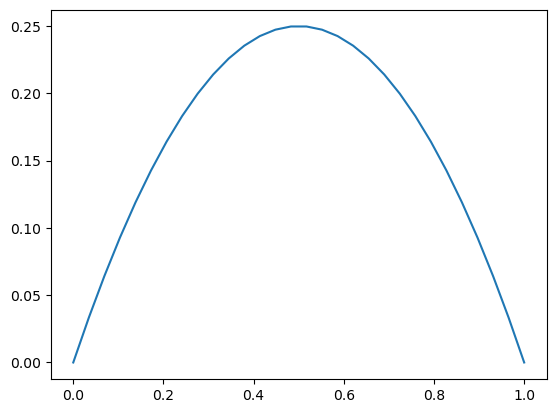

In [28]:
# forcing term
f = x*(1.-x)

plot(x,f)

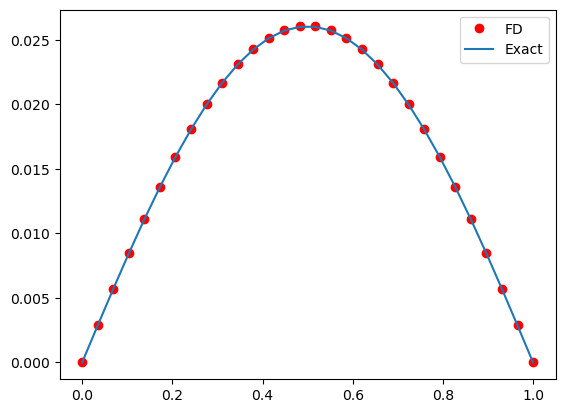

In [29]:
# solve the system using numpy
u = linalg.solve(A, f)
u_ex = (x**4)/12. - (x**3)/6. + x/12.

# plot the FD and exact solution
plot(x,u,'ro',label = 'FD')
plot(x,u_ex, label = 'Exact')
legend()

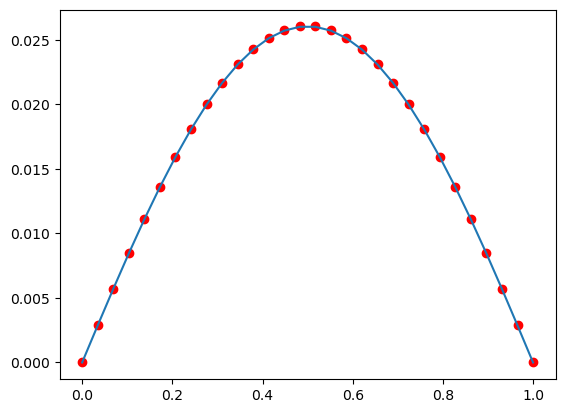

In [30]:
# LU factorization to solve the system

L, U = LU(A)
w = L_solve(L,f)
u = U_solve(U,w)

plot(x,u,'ro',label='computed')
plot(x,u_ex,label='exact')

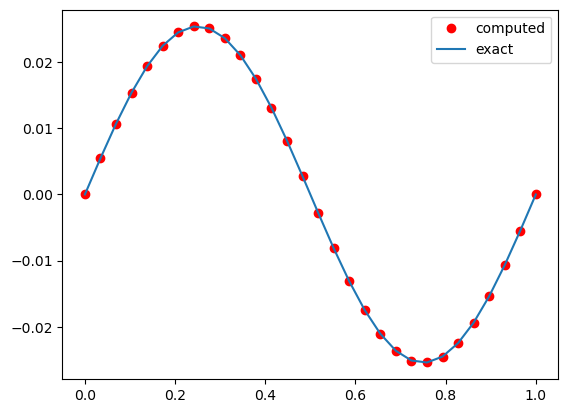

In [32]:
# try to compute the solution u for difference forcing term and compare with the
# exact solution without recomputing the LU decompostion

f = sin(2*pi*x)

w = L_solve(L,f)
u = U_solve(U,w)

u_ex = linalg.solve(A, f)

plot(x,u,'ro',label='computed')
plot(x,u_ex,label='exact')
_=legend()

## Cholesky decomposition

In the case where the $n\times n$ matrix $A$ is symmetric and positive definite, there exists a unique upper triangular matrix
$R$ with positive diagonal elements such that
$$
A = R R^{T},
$$
which is called _Cholesky decomposition_.

The entries of the mtrix $R$ are computed as:
$$
\begin{array}{l}
	r_{11} = \sqrt{a_{11}} \\
	r_{ij} = \frac{1}{r_{jj}} \left( a_{ij} - \sum_{k=1}^{j-1} r_{ki}r_{kj} \right), j=1,\ldots, i-1 \\
	r_{ii} = \sqrt{a_{ii} - \sum_{k=1}^{i-1}r_{ki}^2}
\end{array}
$$

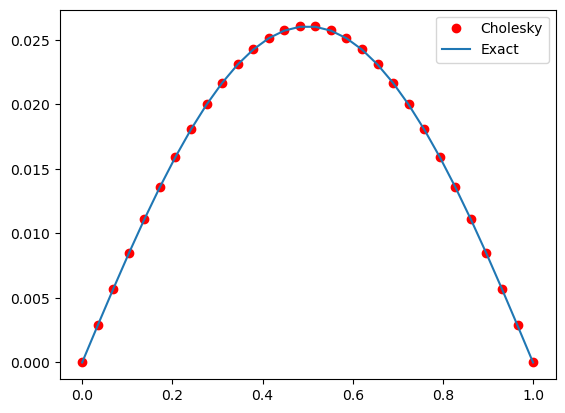

In [31]:
def cholesky(A):
    A = A.copy()
    N = len(A)
    for k in range(N-1):
        A[k,k] = sqrt(A[k,k])
        A[k+1:N,k] = A[k+1:N,k]/A[k,k]

        for j in range(k+1,N):
            A[j:N,j] = A[j:N,j] - A[j:N,k]*A[j,k]

    A[-1,-1] = sqrt(A[-1,-1])
    L=tril(A)
    return L, L.transpose()

HT, H = cholesky(A)
y = L_solve(HT,f)
u = U_solve(H,y)


plot(x,u,'ro', label='Cholesky')
plot(x,u_ex, label='Exact')
legend()

## Gaussian algorithm with pivoting

All steps of the Gaussian elimination algorithm are linear operations on the matrix $A$, and can therefore be represented by suitable matrices. 

### Elimination matrices
Given a vector $x = (x_i)_{i,1,\ldots,n}$ m we can define an _elimination matrix_ E_k(x) such that $x_i=0,\ i=k+1,\ldots,n$.
$$
E_k(x) = I - \hat x^k e_k^{T},
$$
where
$$
\hat x^k = \frac{1}{x_k}[0,\ldots,0,x_{k+1},\ldots,x_{n}]
$$

In [33]:
def elim(x,k):
	n = len(x)
	u = x.copy()
	u = reshape(u,[n,1])
	u[0:k] = 0
	u/=x[k-1]
	ek = zeros([n,1])
	ek[k-1] = 1
	return eye(n) - u@ek.transpose()


In [34]:
x = linspace(0,1,11)
elim(x,3)@x

array([0. , 0.1, 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])

Note that 
$$
(I - \hat x^k e_k^{T})(I + \hat x^k e_k^{T}) = I + \hat x^k e_k^{T} - \hat x^k e_k^{T} - \hat x^k e_k^{T}  \hat x^k e_k^{T} = I,
$$
therefore 
$$
E_k(x)^{-1} = I + \hat x^k e_k^{T},

$$

In [35]:
def invelim(x,k):
	n = len(x)
	u = x.copy()
	u = reshape(u,[n,1])
	u[0:k] = 0
	u/=x[k-1]
	ek = zeros([n,1])
	ek[k-1] = 1
	return eye(n) + u@ek.transpose()

Another interesting feature of these elimination matrices is that they are all lower triangular by construction, and the same is true for their inverses. 

### LU with elimination matrices
It is easy to imagine how to implement the first step of the gaussian elimination algorithm using elimination matrices: 

In [36]:
A = random.randn(5,5)
A

array([[ 1.03875077, -1.66036306,  0.15150056, -0.79181332, -1.36923946],
       [-0.80372451,  0.2474029 ,  0.93883167,  0.20126221,  0.17994744],
       [-0.37491953, -1.26760756,  2.12782969,  1.41180405, -0.11261744],
       [ 0.04528403,  1.29731784, -0.9936094 , -0.61123997,  0.57056975],
       [-0.35863549, -1.16289913, -0.11433172, -1.4167397 ,  0.75528614]])

In [37]:
A1 = elim(A[:,0],1)@A
A1

array([[ 1.03875077, -1.66036306,  0.15150056, -0.79181332, -1.36923946],
       [ 0.        , -1.03728879,  1.05605393, -0.41139656, -0.87948986],
       [ 0.        , -1.86688754,  2.18251126,  1.12601242, -0.60682127],
       [ 0.        ,  1.36970087, -1.00021402, -0.5767211 ,  0.63026133],
       [ 0.        , -1.73615034, -0.06202516, -1.69011842,  0.28254726]])

In [38]:
A2 = elim(A1[:,1],2)@A1
A2

array([[ 1.03875077, -1.66036306,  0.15150056, -0.79181332, -1.36923946],
       [ 0.        , -1.03728879,  1.05605393, -0.41139656, -0.87948986],
       [ 0.        ,  0.        ,  0.28185068,  1.86643411,  0.97606352],
       [ 0.        ,  0.        ,  0.3942655 , -1.1199548 , -0.53107197],
       [ 0.        ,  0.        , -1.82958343, -1.0015481 ,  1.75458342]])

After $n-1$ iterations we have 
$$
E_{n-1} \cdots E_{2}E_{1} A = A_n \text{ upper triangular}
$$
and therefore 
$$
A = E_{1}^{-1}E_{2}^{-1}\cdots E_{n-1}^{-1} A_n.
$$
Since $E_{k}^{-1}$ are lower triangular, we have 
$$
A = LU,\text{ with }
\begin{array}{l}
L = E_{1}^{-1}E_{2}^{-1}\cdots E_{n-1}^{-1} \\ 
U = E_{n-1} \cdots E_{2}E_{1} A
\end{array}.
$$

In [39]:
def LUelim(A):
	'''
	Implementation of LU factorization by elimination matrices
	'''
	n = A.shape[1]
	L = eye(n)
	U = A.copy()

	for k in range(n):
		
		if abs(U[k,k])<=1e-15:
			raise RuntimeError("Null pivot")
		
		E = elim(U[:,k],k+1)
		H = invelim(U[:,k],k+1)

		U = E@U
		L = L@H

	return L,U

### Pivoting with permutation matrices

All the implementations we have see so far assume that at each step $a^{(k)}_{kk} \neq 0$. 
But this is not always guaranteed, or easy to check before starting the elimination procedure. Only a handful of classes of matrices are known to have a $LU$ factorization for sure... 

To remedy, we can use the pivoting technique, which consists in exchanging rows (or columns) of the system so that no pivot is zero. 
This still does not guarantee that the algorithm finishes successfully, but it definitely enlarges the classes of matrices that can be factorized.

Moreover, we can rearrange the row (or columns) of the matrices, so that the pivot is always the biggest available number, so that the computation of the elimination matrices and the backward substitution, which involve a division by the pivots, are more numerically robust. 

**Permutation matrices**

The matrix representing the application that swaps rows $i$ and $j$ of a column vector $x$ is obtained by swapping rows $i$ and $j$ of the identity matrix: 

In [40]:
def perm(i,j,n):
	'''
	Implementation of a permutation matrix
	'''

	P = eye(n)
	P[[i,j],:] = P[[j,i],:]

	return P

In [41]:
print("Permute rows 1 and 2 of\n",A)
print("Result\n",perm(0,1,5)@A)

Permute rows 1 and 2 of
 [[ 1.03875077 -1.66036306  0.15150056 -0.79181332 -1.36923946]
 [-0.80372451  0.2474029   0.93883167  0.20126221  0.17994744]
 [-0.37491953 -1.26760756  2.12782969  1.41180405 -0.11261744]
 [ 0.04528403  1.29731784 -0.9936094  -0.61123997  0.57056975]
 [-0.35863549 -1.16289913 -0.11433172 -1.4167397   0.75528614]]
Result
 [[-0.80372451  0.2474029   0.93883167  0.20126221  0.17994744]
 [ 1.03875077 -1.66036306  0.15150056 -0.79181332 -1.36923946]
 [-0.37491953 -1.26760756  2.12782969  1.41180405 -0.11261744]
 [ 0.04528403  1.29731784 -0.9936094  -0.61123997  0.57056975]
 [-0.35863549 -1.16289913 -0.11433172 -1.4167397   0.75528614]]


Now, in the $LU$ factorization, we can pick at each step the permutation that moves the biggest entry blow the diagonal on the pivot: with this correction we get 
$$
E_{n-1}P_{n-1} \cdots E_2P_2 E_1 P_1 A = U.
$$

The problem now is that the inverse of $E_{n-1}P_{n-1} \cdots E_2P_2 E_1 P_1$, while easy to compute is not in general lower triangular, but we can note that:
- For every $k$, $P_k$ swaps row $k$ with row $l$ with $l\geq k$
- For all $k$, the only non-zeros on $E_k$ are the diagonal and the below-diagonal $k$-th column
Therefore 
$$ 
P_l E_k P_l := E'_k
$$
is lower triangular. 

We can therefore rearrange the above decomposition so to group all permutations matrices together: 
$$
E_{n-1} \left( P_{n-1} E_{n-2} P_{n-1} \right)\cdots \left( P_{n-1}\cdots P_{3} E_2 P_{3}\cdots P_{n-1} \right) \left(P_{n-1}\cdots P_{2} E_1 P_{2}\cdots P_{n-1}\right) P_{n-1}\cdots P_2 P_1 A = U. 
$$
So inverting the modified permutation matrices gives
$$
\begin{split}
L &= \left(P_{n-1}\cdots P_{2} E_1 P_{2}\cdots P_{n-1}\right)^{-1}\left( P_{n-1}\cdots P_{3} E_2 P_{3}\cdots P_{n-1} \right)^{-1} \cdots E_{n-1}^{-1} \\
& = \left(P_{n-1}\cdots P_{2} E_1^{-1} P_{2}\cdots P_{n-1}\right)\left( P_{n-1}\cdots P_{3} E_2^{-1} P_{3}\cdots P_{n-1} \right) \cdots E_{n-1}^{-1} \\
& = P_{n-1}\cdots P_{2} E_1^{-1} P_{2} E_2^{-1} P_3 E_3^{-1} \cdots   P_{n-1} E_{n-1}^{-1}
\end{split} 
$$

So, we have obtained the following decomposition
$$
PA = LU,\quad
\begin{array}{l}
	P = P_{n-1}\cdots P_2 P_1 \\
	L = P_{n-1}\cdots P_{2} E_1^{-1} P_{2} E_2^{-1} P_3 E_3^{-1} \cdots   P_{n-1} E_{n-1}^{-1}  \\
	U = E_{n-1}P_{n-1} \cdots E_2P_2 E_1 P_1 A.
\end{array}
$$

We can then implement the algorithm:

In [42]:
def LUP(A):
	'''
	Implementation of LU decomposition with pivoting
	'''
	assert A.shape[1] == A.shape[0]
	n = A.shape[1]

	L = eye(n)
	P = L.copy()
	U = A.copy()

	for k in range(n):
		idmax = argmax(abs(A[k,k:n])) + k

		Pk = perm(k,idmax,n)
		P = Pk@P
		U = Pk@U
		L = Pk@L@Pk

		if abs(U[k,k])<1e-15:
			raise RuntimeError("Null pivot")
		
		E = elim(U[:,k],k+1)
		H = invelim(U[:,k],k+1)

		U = E@U
		L = L@H

	return L,U,P 

In [43]:
[L,U,P]=LUP(A)